In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import numpy as np
import os
from PIL import Image

import argparse
import torch.nn as nn
import time

from cnn_model import CNN

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomSizedCrop(512), # 224 before，544 is good
        transforms.CenterCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Scale(256),
        transforms.CenterCrop(512), # 224 before
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [2]:
# Default constants
LEARNING_RATE_DEFAULT = 1e-4
BATCH_SIZE_DEFAULT = 10
MAX_EPOCHS_DEFAULT = 1
EVAL_FREQ_DEFAULT = 1
OPTIMIZER_DEFAULT = 'ADAM'

In [3]:
data_dir = './Data/'

train_sets = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=10, shuffle=True, num_workers=4)
train_size = len(train_sets)
train_classes = train_sets.classes

In [4]:
train_sets

Dataset ImageFolder
    Number of datapoints: 11922
    Root Location: ./Data/train
    Transforms (if any): Compose(
                             CenterCrop(size=(512, 512))
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [5]:
train_size

11922

In [6]:
train_classes

['Dorm', 'Gym', 'Library', 'Market', 'TBuilding1']

In [7]:
val_sets = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
val_loader = torch.utils.data.DataLoader(val_sets, batch_size=10, shuffle=False, num_workers=4)
val_size = len(val_sets)

In [8]:
val_sets

Dataset ImageFolder
    Number of datapoints: 500
    Root Location: ./Data/val
    Transforms (if any): Compose(
                             CenterCrop(size=(512, 512))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [9]:
val_size

500

In [10]:
inputs, classes = next(iter(train_loader))

In [11]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


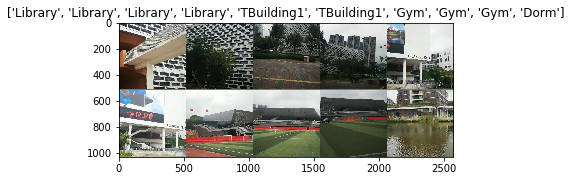

In [12]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=5)

imshow(out, title=[train_classes[x] for x in classes])

In [13]:
inputs.shape

torch.Size([10, 3, 512, 512])

In [14]:
classes

tensor([2, 2, 2, 2, 4, 4, 1, 1, 1, 0])

In [15]:
inputs, classes = next(iter(val_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


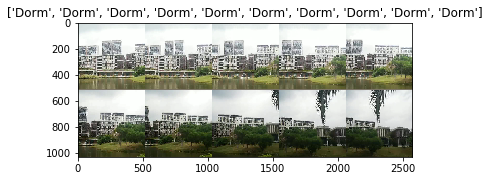

In [16]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=5)


imshow(out, title=[train_classes[x] for x in classes])

In [ ]:
def accuracy(outputs, batch_y):
    """
    Computes the prediction accuracy, i.e., the average of correct predictions
    of the network.
    Args:
        predictions: 2D float array of size [number_of_data_samples, n_classes]
        labels: 2D int array of size [number_of_data_samples, n_classes] with one-hot encoding of ground-truth labels
    Returns:
        accuracy: scalar float, the accuracy of predictions.
    """

    _, predicted = torch.max(outputs.data, 1)
    total = batch_y.size(0)
    correct = (predicted == batch_y).sum().item()
    accuracy = 100.0 * correct / total
    
    
    return accuracy

In [ ]:
def train(trainloader):
    """
    Performs training and evaluation of CNN model.
    NOTE: You should the model on the whole test set each eval_freq iterations.
    """
    # YOUR TRAINING CODE GOES HERE
    n_channels = 3
    n_classes = 5
    
    cnn = CNN(n_channels, n_classes)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    cnn.to(device)
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE_DEFAULT)
    
    losses = []
    accuracies = []
    
    for epoch in range(MAX_EPOCHS_DEFAULT):
        timestart = time.time()
        running_loss = 0.0
        for step, (batch_x, batch_y) in enumerate(trainloader):
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward + Backward + Optimize
            
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#             print("---")
#             print(batch_x.shape)
#             print(batch_y.shape)
            
            outputs = cnn(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if step % EVAL_FREQ_DEFAULT == EVAL_FREQ_DEFAULT-1:  
                print('[epoch: %d, step: %5d] loss: %.4f' %
                          (epoch, step, running_loss / EVAL_FREQ_DEFAULT))
                losses.append(running_loss / EVAL_FREQ_DEFAULT)
                running_loss = 0.0
                accu = accuracy(outputs, batch_y)
                accuracies.append(accu)
                print('Accuracy on the %d train images: %.3f %%' % (batch_y.size(0),
                            accu))
            
        break
        
        print('epoch %d cost %3f sec' %(epoch,time.time()-timestart))
    
    print('---Finished Training---')
    
    return cnn, losses, accuracies

In [ ]:
cnn, losses, accuracies = train(train_loader)

-------
[epoch: 0, step:     0] loss: 1.6128
Accuracy on the 10 train images: 0.000 %
-------
[epoch: 0, step:     1] loss: 1.6044
Accuracy on the 10 train images: 40.000 %
-------
[epoch: 0, step:     2] loss: 1.6096
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:     3] loss: 1.5973
Accuracy on the 10 train images: 60.000 %
-------
[epoch: 0, step:     4] loss: 1.6179
Accuracy on the 10 train images: 0.000 %
-------
[epoch: 0, step:     5] loss: 1.6047
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:     6] loss: 1.5988
Accuracy on the 10 train images: 40.000 %
-------
[epoch: 0, step:     7] loss: 1.6196
Accuracy on the 10 train images: 0.000 %
-------
[epoch: 0, step:     8] loss: 1.6089
Accuracy on the 10 train images: 20.000 %
-------
[epoch: 0, step:     9] loss: 1.6092
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:    10] loss: 1.6083
Accuracy on the 10 train images: 20.000 %
-------
[epoch: 0, step:    11] loss: 1.5957
A

[epoch: 0, step:    95] loss: 1.4754
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:    96] loss: 1.6301
Accuracy on the 10 train images: 10.000 %
-------
[epoch: 0, step:    97] loss: 1.6071
Accuracy on the 10 train images: 10.000 %
-------
[epoch: 0, step:    98] loss: 1.5647
Accuracy on the 10 train images: 10.000 %
-------
[epoch: 0, step:    99] loss: 1.4919
Accuracy on the 10 train images: 40.000 %
-------
[epoch: 0, step:   100] loss: 1.4698
Accuracy on the 10 train images: 20.000 %
-------
[epoch: 0, step:   101] loss: 1.4412
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:   102] loss: 1.2809
Accuracy on the 10 train images: 50.000 %
-------
[epoch: 0, step:   103] loss: 1.3922
Accuracy on the 10 train images: 20.000 %
-------
[epoch: 0, step:   104] loss: 1.0180
Accuracy on the 10 train images: 50.000 %
-------
[epoch: 0, step:   105] loss: 1.5480
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:   106] loss: 1.3418
Accura

[epoch: 0, step:   190] loss: 0.8602
Accuracy on the 10 train images: 50.000 %
-------
[epoch: 0, step:   191] loss: 1.4654
Accuracy on the 10 train images: 40.000 %
-------
[epoch: 0, step:   192] loss: 0.7649
Accuracy on the 10 train images: 70.000 %
-------
[epoch: 0, step:   193] loss: 0.7713
Accuracy on the 10 train images: 70.000 %
-------
[epoch: 0, step:   194] loss: 0.7928
Accuracy on the 10 train images: 60.000 %
-------
[epoch: 0, step:   195] loss: 1.1838
Accuracy on the 10 train images: 20.000 %
-------
[epoch: 0, step:   196] loss: 1.0090
Accuracy on the 10 train images: 80.000 %
-------
[epoch: 0, step:   197] loss: 1.1055
Accuracy on the 10 train images: 40.000 %
-------
[epoch: 0, step:   198] loss: 1.4086
Accuracy on the 10 train images: 30.000 %
-------
[epoch: 0, step:   199] loss: 0.9676
Accuracy on the 10 train images: 70.000 %
-------
[epoch: 0, step:   200] loss: 0.7434
Accuracy on the 10 train images: 90.000 %
-------
[epoch: 0, step:   201] loss: 1.0762
Accura